In [58]:
import pathlib, shutil, tempfile

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 102s 0us/step


In [7]:
FEATURES = 28

In [8]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type='GZIP')

In [9]:
ds

<CsvDatasetV2 shapes: ((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [10]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


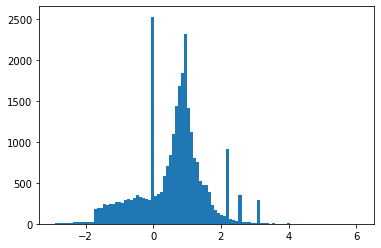

In [12]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [14]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [15]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [17]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [18]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [21]:
lr_schedule = InverseTimeDecay(0.001, 
                               decay_steps=STEPS_PER_EPOCH*1000,
                               decay_rate=1,
                               staircase=False)

def get_optimizer():
    return Adam(lr_schedule)

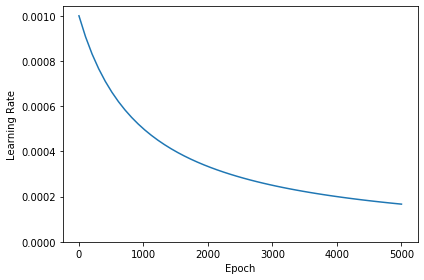

In [22]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.tight_layout()

In [33]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        TensorBoard(logdir/name),
    ]

In [34]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'binary_crossentropy'])
    
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [35]:
tiny_model = tf.keras.Sequential([
    Dense(16, activation='elu', input_shape=(FEATURES,)),
    Dense(1, activation='sigmoid')
])

In [36]:
size_histories = {}

In [37]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5232,  binary_crossentropy:0.9821,  loss:0.9821,  val_accuracy:0.5200,  val_binary_crossentropy:0.8291,  val_loss:0.8291,  
....................................................................................................
Epoch: 100, accuracy:0.6403,  binary_crossentropy:0.6291,  loss:0.6291,  val_accuracy:0.6550,  val_binary_crossentropy:0.6241,  val_loss:0.6241,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

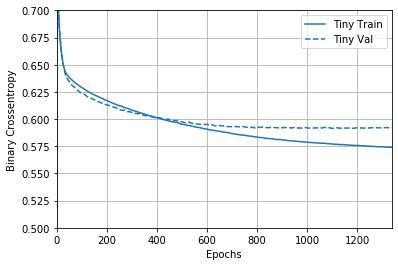

In [38]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',
                                      smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [39]:
small_model = Sequential([
    Dense(16, activation='elu', input_shape=(FEATURES,)),
    Dense(16, activation='elu'),
    Dense(1, activation='sigmoid')
])

In [40]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4848,  binary_crossentropy:0.7187,  loss:0.7187,  val_accuracy:0.5140,  val_binary_crossentropy:0.7012,  val_loss:0.7012,  
....................................................................................................
Epoch: 100, accuracy:0.6581,  binary_crossentropy:0.6165,  loss:0.6165,  val_accuracy:0.6400,  val_binary_crossentropy:0.6223,  val_loss:0.

In [41]:
medium_model = Sequential([
    Dense(64, activation='elu', input_shape=(FEATURES,)),
    Dense(64, activation='elu'),
    Dense(64, activation='elu'),
    Dense(1, activation='sigmoid')
])

In [42]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5432,  binary_crossentropy:0.6944,  loss:0.6944,  val_accuracy:0.5850,  val_binary_crossentropy:0.6781,  val_loss:0.6781,  
....................................................................................................
E

In [43]:
large_model = Sequential([
    Dense(512, activation='elu', input_shape=(FEATURES,)),
    Dense(512, activation='elu'),
    Dense(512, activation='elu'),
    Dense(512, activation='elu'),
    Dense(1, activation='sigmoid')
])

In [44]:
size_histories['large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5276,  binary_crossentropy:0.7606,  loss:0.7606,  val_accuracy:0.5390,  val_binary_crossentr

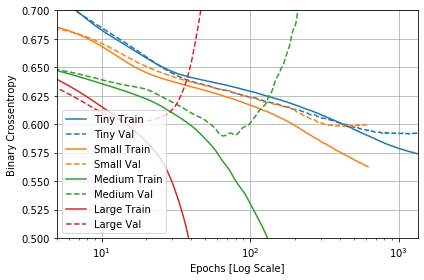

In [45]:
plotter.plot(size_histories)
plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Epochs [Log Scale]')
plt.tight_layout()

In [48]:
%tensorboard --logdir {logdir}/sizes

In [49]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpc_09khfo/tensorboard_logs/regularizers/Tiny')

In [50]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [56]:
l2_model = Sequential([
    Dense(512, activation='elu',
          kernel_regularizer=l2(0.0001),
          input_shape=(FEATURES,)),
    Dense(512, activation='elu',
          kernel_regularizer=l2(0.0001)),
    Dense(512, activation='elu',
          kernel_regularizer=l2(0.0001)),
    Dense(512, activation='elu',
          kernel_regularizer=l2(0.0001)),
    Dense(1, activation='sigmoid')
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5235,  binary_crossentropy:0.7739,  loss:0.9317,  val_accuracy:0.5630,  val_binary_crossentr

In [54]:
l1_model = Seregularizer_historiestial([
    Dense(512, activation='elu',
          kernel_regularizer=l1(0.0001),
          input_shape=(FEATURES,)),
    Dense(512, activation='elu',
          kernel_regularizer=l1(0.0001)),
    Dense(512, activation='elu',
          kernel_regularizer=l1(0.0001)),
    Dense(512, activation='elu',
          kernel_regularizer=l1(0.0001)),
    Dense(1, activation='sigmoid')
])

regularizer_histories['l1'] = compile_and_fit(l1_model, 'regularizers/l1')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5072,  binary_crossentropy:0.7893,  loss:3.7591,  val_accuracy:0.5550,  val_binary_crossentr

(0.5, 0.7)

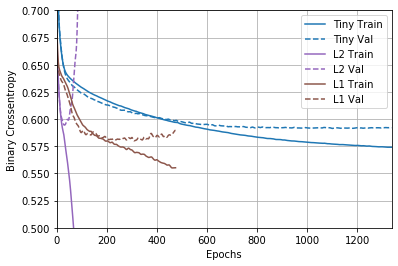

In [57]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [59]:
dropout_model = Sequential([
    Dense(512, activation='elu', input_shape=(FEATURES,)),
    Dropout(0.5),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)              

(0.5, 0.7)

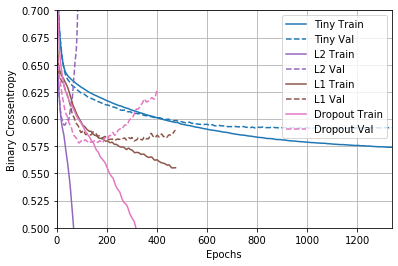

In [60]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [62]:
l2_dropout_model = Sequential([
    Dense(512, kernel_regularizer=l2(0.0001),
          activation='elu', input_shape=(FEATURES,)),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l2(0.0001),
          activation='elu'),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l2(0.0001),
          activation='elu'),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l2(0.0001),
          activation='elu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

regularizer_histories['l2_dropout'] = compile_and_fit(l2_dropout_model, 'regularizers/l2_dropout')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)             

In [63]:
l1_dropout_model = Sequential([
    Dense(512, kernel_regularizer=l1(0.0001),
          activation='elu', input_shape=(FEATURES,)),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l1(0.0001),
          activation='elu'),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l1(0.0001),
          activation='elu'),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l1(0.0001),
          activation='elu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

regularizer_histories['l1_dropout'] = compile_and_fit(l1_dropout_model, 'regularizers/l1_dropout')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)             

(0.5, 0.7)

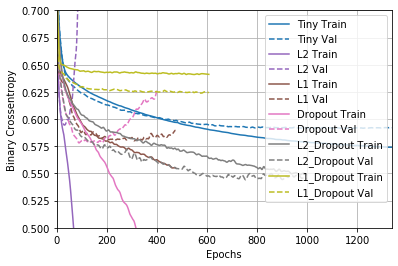

In [64]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])